<table style="background-color: rgb(13,32,76); border-radius: 10px">
	<thead>
		<tr>
			<th colspan="2" style="border: hidden; vertical-align: top;" width="15%"><img src="https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1674755226__Icons_400px_Practice Assignment.png">
			</th>
			<th style="border: hidden;">
				<h1 style="color: white;">MA Models (Practice)</h1>
			</th>
		</tr>
	</thead>
</table>
<p>This practice assignment will reinforce important learning objectives from the previous lesson(s), and allow you to take on more challenging core assignments, preparing you for graduation.<br></p>
<p>Practice and tinker with this assignment until you're comfortable performing each of the tasks. Then, be sure to submit your output as described in the steps below.</p>
<hr>
<h2><span style="background-color: initial; font-family: Gotham-Rounded-Bold; font-size: 24px;">MA Models (Practice)</span></h2>
<p>We will revisit the basic white noise, random walk, and random walk with drift data that we generated in earlier lessons.</p>
<p>We have combined the 3 time series into a single csv that you can access <a href="https://drive.google.com/file/d/1KInPrtIaxJBhi5BwA-RGaQgEIYpYwWYX/view?usp=sharing" target="_blank" style="background-color: rgb(255, 255, 255);">here.</a>  </p>
<pre class="rainbow" data-language="python"># Read in data
df  = pd.read_csv("Data/constructed-basic-time-series.csv", index_col=0,
                 parse_dates=[0])
# Resample to day
df = df.resample("D").asfreq()
df.info()
df.head()
</pre>
<p>After loading, split the dataframe into the separate time series:<br></p>
<pre class="rainbow" data-language="python"># Define each as a separate time series
ts_wn = df["White Noise"]
ts_rw = df['Random Walk']
ts_rwd = df['Random Walk + Drift']</pre>
<p><br></p>
<p>For each time series, </p>
<ul><li>Plot the time series</li><li>Check for stationarity</li><li>Determine if differencing is needed</li><li>View the ACF plot for the differenced data to estimate the number of lags to try for q.</li><li>Split the data into train so that the test is 2 weeks (test_size = 14)</li><li>Visualize the train test split</li><li>Fit an MA-only model with q lags.</li><li>Visualize the true versus forecasted values.</li><li>Evaluate with regression metrics, including MAPE.</li></ul>
<p><br></p>

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
# set random seed
SEED = 321
np.random.seed(SEED)
# Fig settings
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
# Read in data
df  = pd.read_csv("Data/constructed-basic-time-series.csv", index_col=0,
                 parse_dates=[0])
# Resample to day
df = df.resample("D").asfreq()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2023-01-01 to 2023-04-30
Freq: D
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   White Noise          120 non-null    float64
 1   Random Walk          120 non-null    float64
 2   Random Walk + Drift  120 non-null    float64
dtypes: float64(3)
memory usage: 3.8 KB


,White Noise,Random Walk,Random Walk + Drift
2023-01-01,50.635483,150.000000,150.000000
2023-01-02,49.037336,148.598865,150.871668
2023-01-03,48.115850,147.131094,150.629815
2023-01-04,47.856808,148.014590,150.597118
2023-01-05,48.378634,147.161973,150.516326


In [6]:
# Define each as a separate time series
ts_wn = df["White Noise"]
ts_rw = df['Random Walk']
ts_rwd = df['Random Walk + Drift']

## White Noise

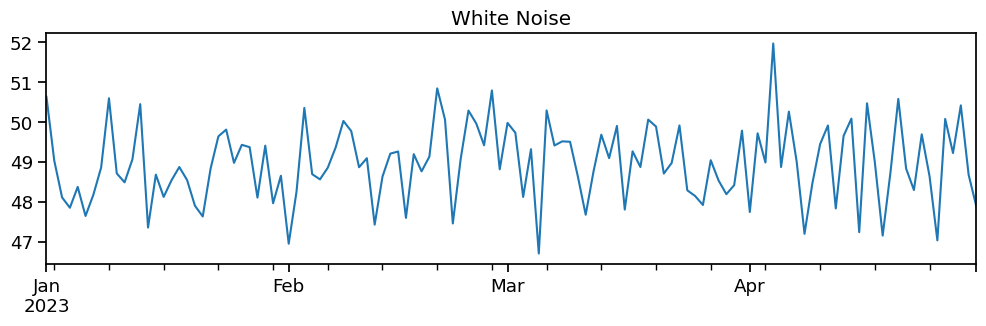

In [7]:
# plot white noise
ax = ts_wn.plot()
ax.set_title("White Noise");

In [8]:
# Check for stationarity
get_adfuller_results(ts_wn)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-11.13386,0,119,0.0,0.05,True


Our white noise time series is stationary, so we will not apply differencing (d = 0)

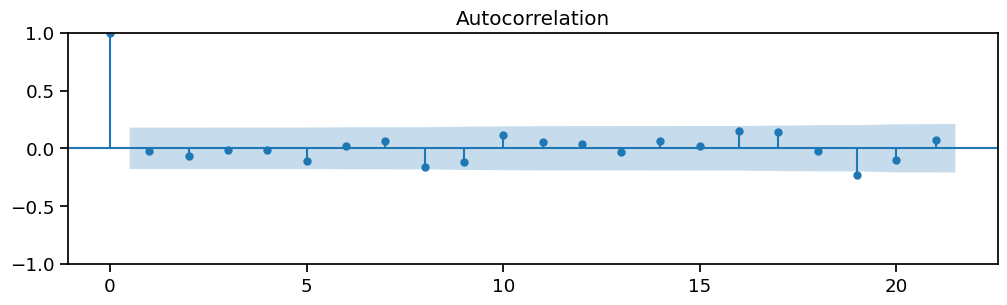

In [9]:
# Create ACF plot of white noise (raw data is stationary so using it here)
fig = tsa.graphics.plot_acf(ts_wn)

Based on ACF, use MA(1). Set q = 1.

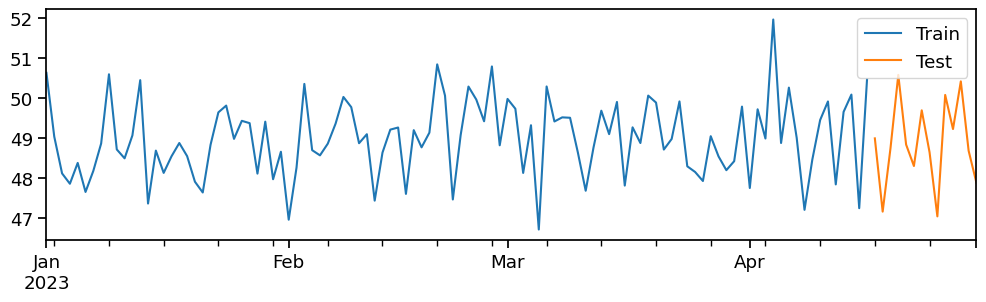

In [10]:
# Train test split time series data
train_wn, test_wn = train_test_split(ts_wn, test_size=14)

# Plot the results
ax = train_wn.plot(label='Train')
test_wn.plot(ax=ax, label='Test')
ax.legend();

In [11]:
# Fit an MA-only model on white noise data (0, 0, 1)
# No AR component
p = 0 

# no differencing (already stationary)
d = 0 

# MA() based on ACF
q = 1 

ma_1_model_wn = tsa.ARIMA(train_wn, enforce_invertibility=False, order=(p,d,q)).fit()

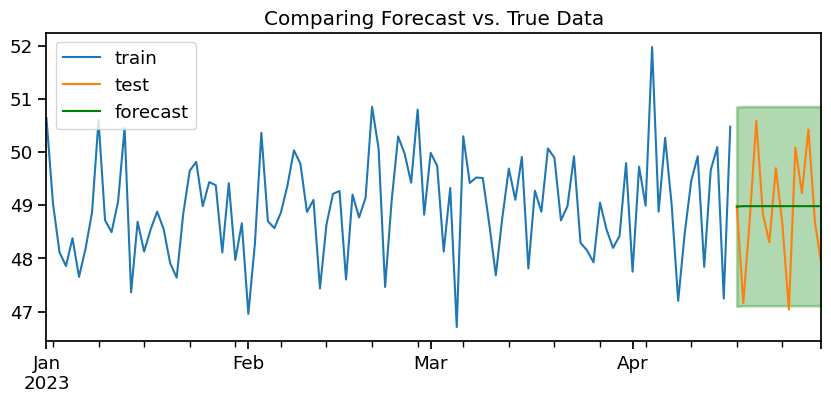

In [12]:
# Obtain forecast as df
forecast_df_wn = ma_1_model_wn.get_forecast(len(test_wn)).summary_frame()

# Plot with custom function
plot_forecast(train_wn, test_wn, forecast_df_wn);

In [13]:
# Call custom function to evaluate
regression_metrics_ts(test_wn, forecast_df_wn['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 0.835
- MSE = 1.105
- RMSE = 1.051
- R^2 = -0.010
- MAPE = 1.71%


MA(1) does a good job of predicting white noise model

## Random Walk (no drift)

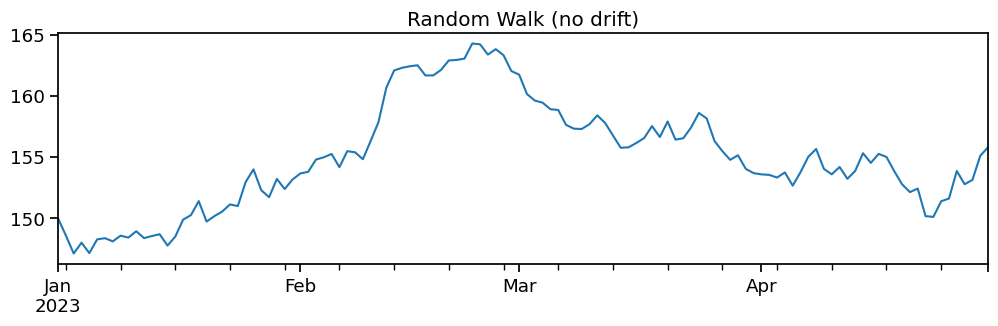

In [14]:
# plot randow walk
ax= ts_rw.plot()
ax.set_title("Random Walk (no drift)");

In [15]:
# Check for stationarity
get_adfuller_results(ts_rw)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.442588,0,119,0.561697,0.05,False


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-10.109419,0,118,0.0,0.05,True


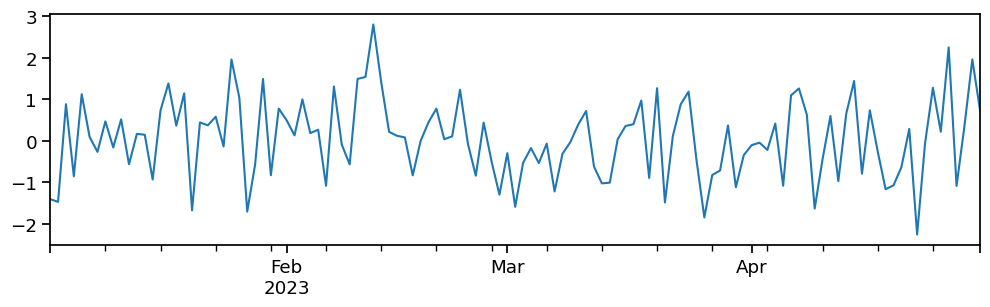

In [16]:
# Difference the data in the random walk
rw_diff = ts_rw.diff().dropna()
rw_diff.plot()

# Confirm the differenced data is stationary
get_adfuller_results(rw_diff)

One differencing was sufficient to make the rw stationary, so we will use d = 1.

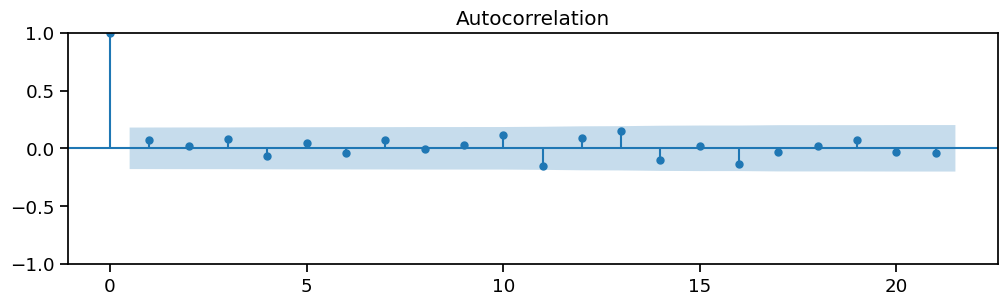

In [17]:
# Create ACF plot of random walk using the differenced data
fig = tsa.graphics.plot_acf(rw_diff)

Based on ACF, we estimate an order of 1 for MA. q = 1

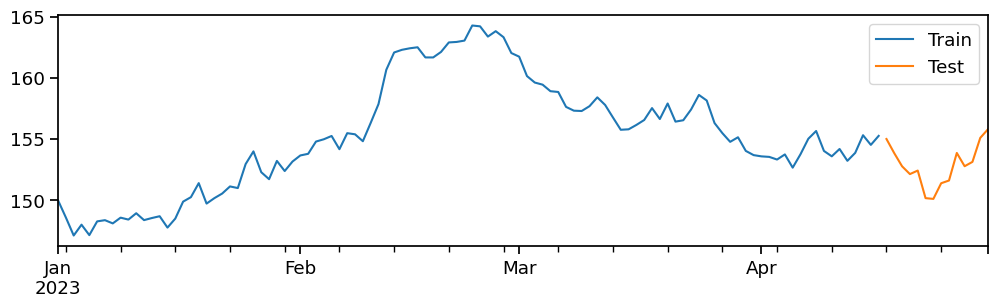

In [18]:
# Split random walk ts into train and test
train_rw, test_rw = train_test_split(ts_rw, test_size=14)

# Plot train and test
ax = train_rw.plot(label='Train')
test_rw.plot(ax=ax, label='Test')
ax.legend();

In [19]:
# Make MA-only model for Random Walk (0, 1, 1)

# No AR component
p = 0 

# 1 differencing to make stationary
d = 1 

# MA() based on ACF plot
q = 1 

ma_1_model_rw = tsa.ARIMA(train_rw, 
                          enforce_invertibility=False,
                          order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.520
- MSE = 8.826
- RMSE = 2.971
- R^2 = -2.126
- MAPE = 1.66%


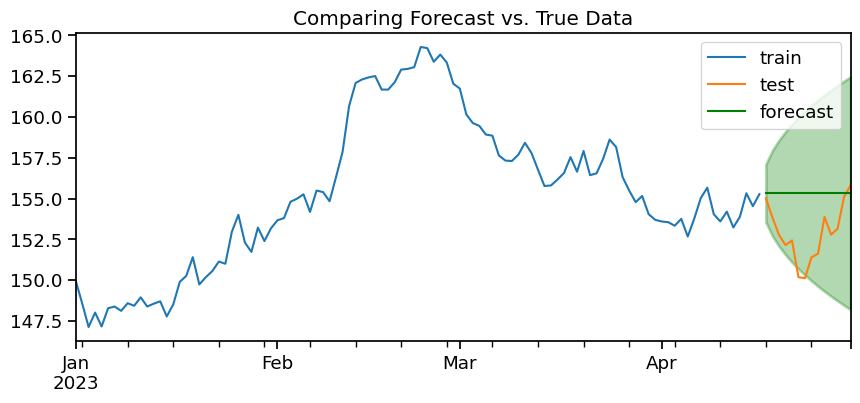

In [21]:
# Obtain forecast as df
forecast_df_rw = ma_1_model_rw.get_forecast(len(test_rw)).summary_frame()

# Plot forecast
plot_forecast(train_rw, test_rw, forecast_df_rw)

# Obtain metrics
regression_metrics_ts(test_rw, forecast_df_rw['mean'])

## Random Walk with Drift

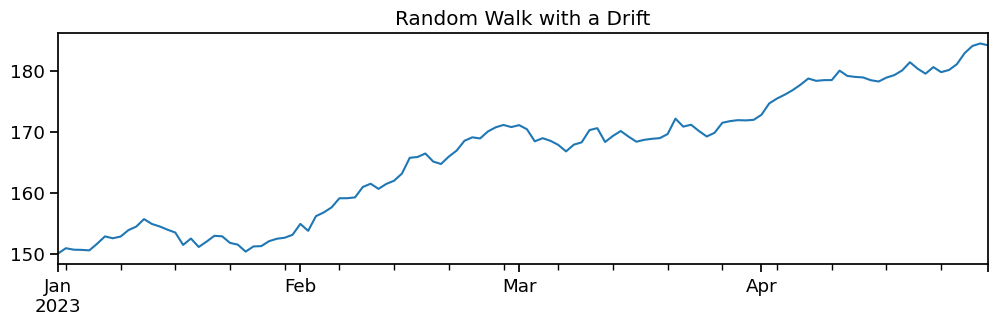

In [22]:
# Visualize the random walk with a drift data
ax = ts_rwd.plot()
ax.set_title("Random Walk with a Drift");

In [23]:
# Check for stationarity
get_adfuller_results(ts_rwd)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-0.189886,0,119,0.939716,0.05,False


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-10.45481,0,118,0.0,0.05,True


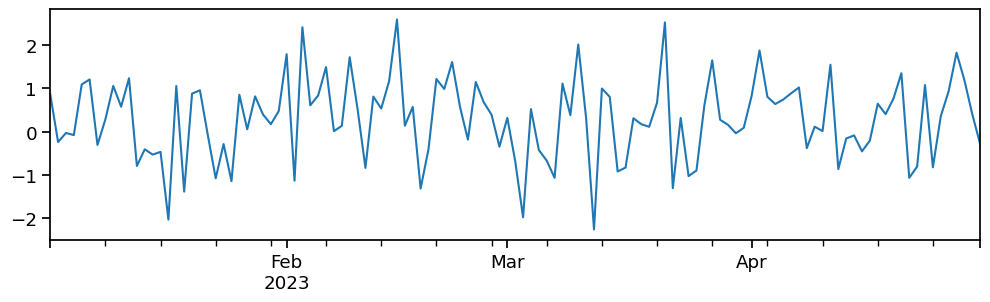

In [24]:
# Difference the data in the random walk with drift
rwd_diff = ts_rwd.diff().dropna()
rwd_diff.plot()

# Confirm the differenced data is stationary
get_adfuller_results(rwd_diff)

One differencing is sufficient so we will use d = 1

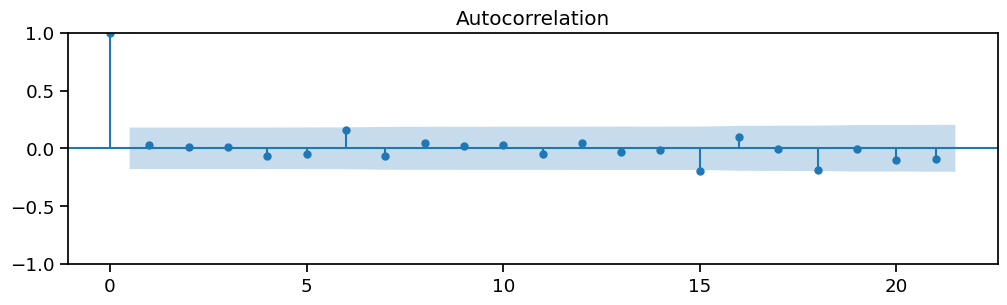

In [26]:
# Create ACF plot of stationary data
fig = tsa.graphics.plot_acf(rwd_diff)

Based on ACF, we estimate order of MA(1). We will use q = 1

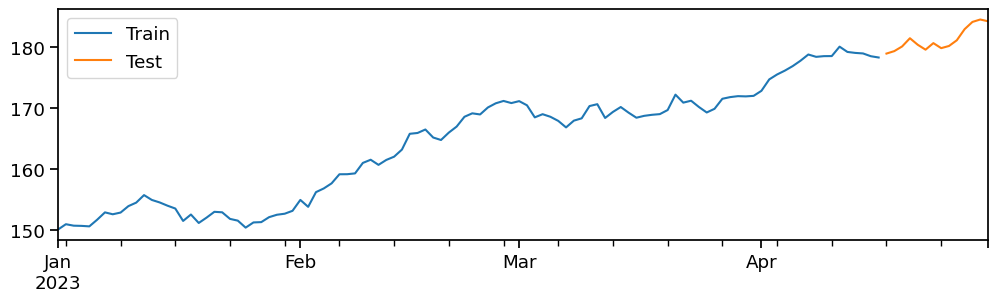

In [27]:
# TTS random walk with drift data
train_rwd, test_rwd = train_test_split(ts_rwd, test_size=14)

# Visualize the split
ax = train_rwd.plot(label='Train')
test_rwd.plot(ax=ax, label='Test')
ax.legend();

In [28]:
# Fit an MA-only  model on the random walk w/drift data (0,1,1)

# No AR component
p = 0 

# 1 differencing to make stationary
d = 1 

# MA() based on ACF plot
q = 1

ma_1_model_rwd = tsa.ARIMA(train_rwd, enforce_invertibility=False,
                           order=(p,d,q)).fit()


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.972
- MSE = 12.296
- RMSE = 3.507
- R^2 = -2.549
- MAPE = 1.63%


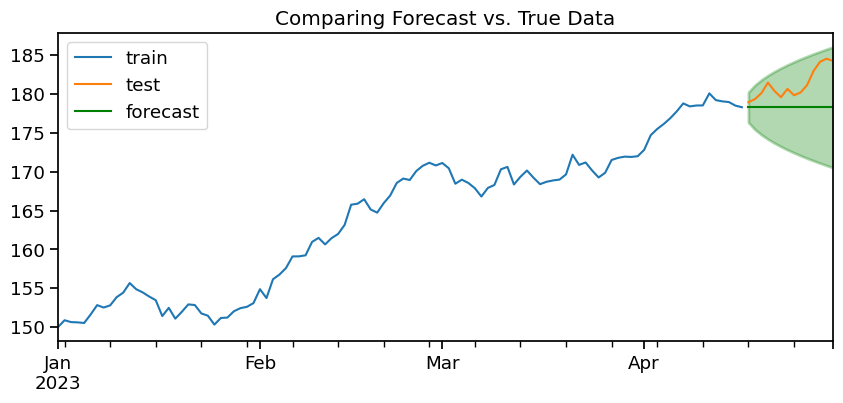

In [29]:
# Get the forecast as a summary dataframe
forecast_df_rwd = ma_1_model_rwd.get_forecast(len(test_rwd)).summary_frame()
# Plot the forecast and true values
plot_forecast(train_rwd, test_rwd, forecast_df_rwd)
# Obtain metrics
regression_metrics_ts(test_rwd, forecast_df_rwd['mean'])